Notebook per fare il Training e il Testing del modello per la classe di centralità 10-40 % per fare il confronto con i risultati dell'analisi standard. Nella prima parte del notebook Training e Testing, nella seconda viene stimata la Significance che si otterrebbe misurando lo yield. 

In [14]:
%pylab inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pickle

%run analysis_utils.py

Populating the interactive namespace from numpy and matplotlib


In [13]:
training = False

## Data preliminary

Carico i dati, defisco le variabili su cui fare Training e preparo il Training Set.

In [15]:
df_ML = pd.read_pickle('/home/fmazzasc/HyperML_Local/df_ML.pkl')

bkg = df_ML.query('y==0')
sig = df_ML.query('y==1')

In [16]:
data = pd.concat([bkg,sig],ignore_index=True)
data = data.sample(frac=1)

In [17]:
training_columns = [ 'V0CosPA','ProngsDCA', 'DistOverP', 'ArmenterosAlpha','NpidClustersHe3','V0pt','TPCnSigmaHe3']

In [18]:
df = data.query('10<=Centrality<=40')
traindata,testdata,ytrain,ytest = train_test_split(df, df['y'], test_size=0.5)

Plotto le variabili di Training del segnale e del fondo come confronto e la matrice delle correlazioni.

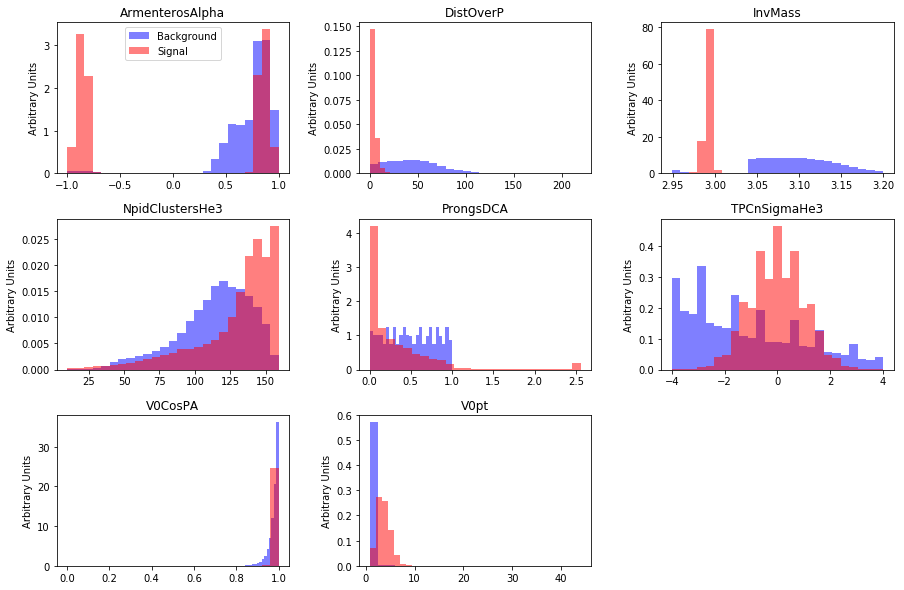

In [19]:
plot_distr(data,training_columns+['InvMass'])

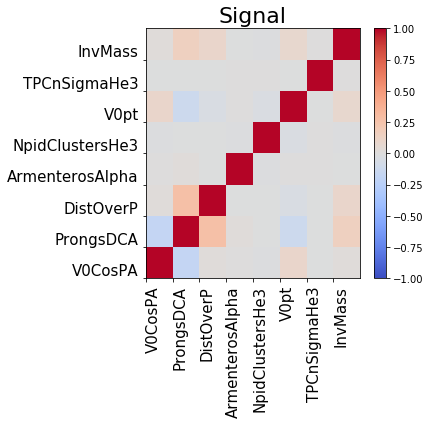

In [20]:
plot_corr(data,training_columns+['InvMass'],"Signal")

## Training

For using pre-trained models skip to the Testing part.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
scoring = 'auc'
early_stopping_rounds = 20
num_rounds = 200
params_def = {
    # Parameters that we are going to tune.
    'max_depth':8,
    'eta':0.05,
    'gamma':0.7,
    'min_child_weight':8,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
    'random_state':42,
    'silent':1,
    'nthread':4,
    'tree_method':'hist'}

In [ ]:
params = params_def
dtrain = xgb.DMatrix(data=np.asarray(traindata[training_columns]), label=ytrain, feature_names=training_columns)
model_cent_integr = xgb.train(params, dtrain,num_boost_round=num_rounds) 

In [ ]:
# saving the model
pickle.dump(model_cent_integr,open("model_10_40.pkl", "wb"))

## Testing

If you skip the Training start from here.

In [21]:
if training:
    model = model_cent_integr
else:
    model = pickle.load(open("/home/fmazzasc/HyperML_Local/Significance/model_0_40.pkl", "rb"))

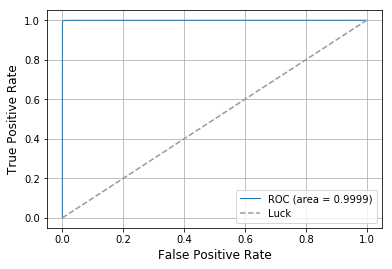

In [22]:
dtest = xgb.DMatrix(data=testdata[training_columns])
y_pred = model.predict(dtest,output_margin=True)
plot_roc(ytest,y_pred)

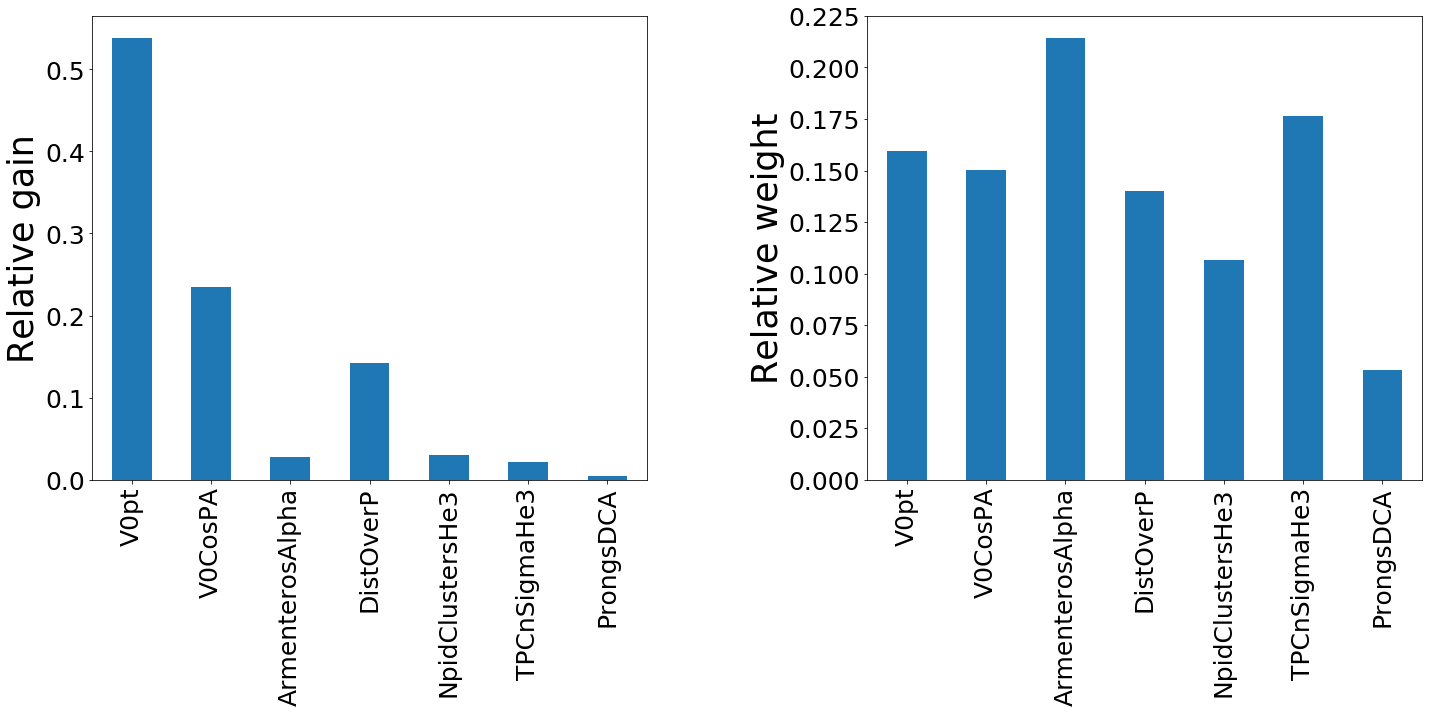

In [23]:
plot_feature_imp(model,['gain','weight'])

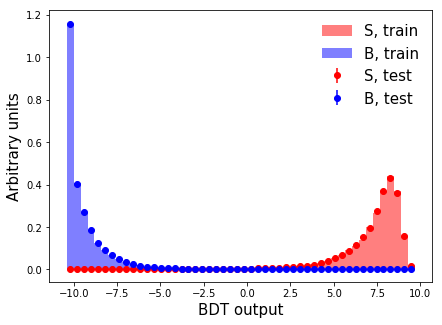

In [24]:
plot_output_train_test(model, traindata[training_columns], ytrain, testdata[training_columns], ytest, branch_names=training_columns,raw=True)

## BDT Efficiency 

Calcolo l'efficienza del modello in funzione dello Score.

<Figure size 432x288 with 0 Axes>

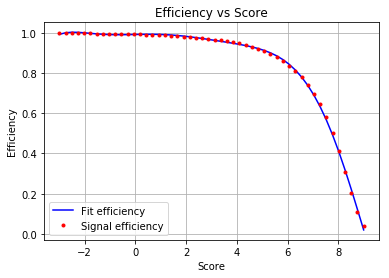

<Figure size 432x288 with 0 Axes>

In [25]:
testdata.eval('Score = @y_pred',inplace=True)
efficiency_array=EfficiencyVsCuts(testdata)
plt.figure() 

In [26]:
np.save("efficiency_10_40_array",efficiency_array)

# Significance Scan Vs pT

Scan della Significance Vs BDT Score negli stessi bin di pT in cui Stefano ha estratto lo yield doppio differenziale per confrontare la massima sign. ottenibile con il BDT con la sign. ottenuta con il metodo standard. Eventi in classe di centralità 10-40%.

### Carico i dati  in centralità 10-40%

In [28]:
# For starting from here uncomment the model loading
df_18r = pd.read_pickle('/home/fmazzasc/HyperML_Local/df_Sig_data.pkl')

df_18r = df_18r.astype('float')
df_18r = df_18r.query('10<=Centrality<=40')
model = pickle.load(open("/home/fmazzasc/HyperML_Local/Significance/model_0_40.pkl", "rb"))
efficiency_array = np.load("efficiency_10_40_array.npy", 'r')

### Funzioni di servizio

In [35]:
def ExpectedSignal(eff_bdt, i):
    n_ev = 20436460
    yield_meas = [1e-5,8e-6,4e-6,9e-7] # values taken from S.Trogolo PhD Thesis
    eff_V0 = [0.0819,0.1172,0.1439,0.1650] # values computed in eff2body.cc macro
    dpT = [1,1,1,4]
    return int(round(2*n_ev*yield_meas[i]*dpT[i]*eff_V0[i]*eff_bdt))

In [ ]:
def SignificanceScan(df, pT_min, pT_max, i_pT):    
    signal_array = []
    significance_array = []
    custom_score_array = []
    score_list = np.linspace(-3,9,50)
    index = 0
    
    for i in score_list:
        df_score = df.query('Score>@i and V0pt>=@pT_min and V0pt<=@pT_max')['InvMass']
        counts,bins = np.histogram(df_score,bins=25,range=[2.96,3.05]);
        bin_centers = 0.5*(bins[1:]+bins[:-1])
        sidemap = (bin_centers<2.9923-3*0.0025) + (bin_centers>2.9923+3*0.0025)
        massmap = logical_not(sidemap)
        bins_side = bin_centers[sidemap]
        counts_side = counts[sidemap]
        h, residuals, _, _, _ = polyfit(bins_side,counts_side,2,full=True)
        chisq_dof = residuals / (len(bins_side) - 3)
        y = polyval(h,bins_side)
        signal = ExpectedSignal(efficiency_array[index], i_pT)
        bkg = sum(polyval(h,bin_centers[massmap]))
        significance = signal/sqrt(signal+bkg)
        signal_array.append(signal)
        significance_array.append(significance)
        custom_score = significance*efficiency_array[index]
        custom_score_array.append(custom_score)
        index += 1
        
    max_index = np.argmax(significance_array)
    max_score = score_list[max_index]
    ryield = signal_array[max_index]
    df_cut = df.query('Score>@max_score')['InvMass']
    signal_mc=np.random.normal(2.9923,0.0025,ryield)
    counts_mc,_= np.histogram(df_cut,bins=25,range=[2.96,3.05]);
    counts_data,_ = np.histogram(df_cut,bins=25,range=[2.96,3.05]);
    h = polyfit(bins_side,counts_data[sidemap],2)
    counts_bkg = polyval(h,bin_centers)
    counts_tot=counts_bkg+counts_mc
    fig, axs = plt.subplots(1,3, figsize=(12, 3))   
    axs[0].plot(score_list,significance_array,'b')
    axs[0].set_xlabel('Score')
    axs[0].set_ylabel('Significance')
    axs[1].plot(bin_centers[sidemap],counts_data[sidemap],'b.')
    axs[1].plot(bin_centers[massmap],counts_tot[massmap],'g.')    
    axs[1].plot(bin_centers[sidemap],counts_bkg[sidemap],'r-')
    axs[1].set_xlabel('InvMass')
    axs[1].set_ylabel('Counts')
    axs[2].plot(score_list,custom_score_array,'b')
    axs[2].set_xlabel('Score')
    axs[2].set_ylabel('Custom Score')
    plt.suptitle(r"%1.f $ \leq \rm{p}_{T} \leq $ %1.f, Best Score = %0.2f, Significance = %0.2f, Raw yield = %0.2f" %(pT_min,pT_max,max_score,np.max(significance_array),ryield))
    signal_array = np.asarray(signal_array)
    plt.show()
    return max_score

In [ ]:
pT_list = [[2,3],[3,4], [4,5],[5,9]]
best_score_list=[]

for i in range(0,4):
    plt.figure();
    dtest = xgb.DMatrix(data=df_18r[training_columns],silent=True)
    df_18r['Score'] = model.predict(dtest,output_margin=True)
    best_score_list.append(SignificanceScan(df_18r,pT_list[i][0],pT_list[i][1],i))
    del dtest